# Imports

In [347]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv
import h5py

#custom analysis packages
import aster_packages as ap

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 4
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy" #chick this later maybe the source of weirdness in labels (ANA READ THIS)
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
plt.rcParams.update({"text.usetex": True, 
             "font.family": "Times"})
mpl.rc("figure", dpi=200)

color_background = '#E5E0D5'

# Data Imports

Function to import aster images into a list of length 3 each containing an image array for each channel with shape (lenth of frames, n by m image shape)

In [5]:
def parse_ome(file, channel_list=['405', '480', 'Cherry']):
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata

    ch1 = images[0::3]
    ch2 = images[1::3]
    ch3 = images[2::3]
    
    return [np.array(ch1), np.array(ch2), np.array(ch3)]

In [6]:
#gabes version of file name
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
arrs = parse_ome(gname)

In [8]:
def grab_expparams_ome(gname):
    '''
    assumes unix file separation - rewrite if you have a PC
    '''
    exp_file = gname.split('/')[-1]
    interval = int(exp_file.split('sInter')[0])
    motor_conc = float(exp_file.split('_')[1].split('uM')[0])
    motor_type = exp_file.split('_')[2]
    ATP_conc = float(exp_file.split('_')[4].split('uM')[0])
    tubulin_conc = float(exp_file.split('_')[5].split('uM')[0])
    probe_conc = float(exp_file.split('_')[7].split('uM')[0])
    probe_type = exp_file.split('_')[8]
    
    exp_params = {'exp_file':exp_file,
                 'interval':interval,
                 'motor_conc':motor_conc,
                 'motor_type':motor_type,
                 'ATP_conc':ATP_conc,
                 'tubulin_conc':tubulin_conc,
                 'probe_conc':probe_conc,
                 'probe_type':probe_type}
    return exp_params

In [9]:
exp_params = grab_expparams_ome(gname)

# prev version importing already broken up ome into folders of tifs

# end

In [11]:
def grab_dark_avg(file_path_dark):
    """
    input for example:
    file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

In [42]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)

In [13]:
def grab_calparams(file_path_cal):
    #read the DataFrame
    cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

In [43]:
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_params = grab_calparams(cal_file_path+cal_file_folder+cal_file_name)

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

In [14]:
def backSubtract(arrs, dark_avg):
    return [arr-dark_avg for arr in arrs] # save processed images

In [44]:
arrs_sub = backSubtract(arrs, dark_avg)

In [15]:
def intersect(arrs):
    _, numRows, numCols=arrs[0].shape
    
    #iterate through frame numbers
    severeIntersection=np.ones_like(arrs[0][0]);
    
    for fr in range(arrs[0].shape[0]): # for every timepoint
        #iterate through channels:
        ## Process the ATP channels first!
        im_bins=[]
        for arr in arrs[:2]: #exclude the motor channel!
            im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
            im_bins.append(im_bin)
        intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
        severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

    return np.where(severeIntersection.astype(int)) #returns where =1 (or True)

In [45]:
mask_coords=intersect(arrs_sub)
allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

In [16]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [17]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        
        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

In [46]:
arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_23322/4270752263.py:13: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


# Ratio

In [47]:
ratios = arrs_norm[0][allmask_coords]/arrs_norm[1][allmask_coords]

In [18]:
def replace_out_of_range_values(arr, min_value, max_value):
    arr_copy = np.copy(arr)
    mask_min = arr < min_value
    mask_max = arr > max_value
    arr_copy[mask_min] = min_value
    arr_copy[mask_max] = max_value
    return arr_copy

In [19]:
def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

In [20]:
def infer_concs(ratios, exp_params, cal_params, allmask_coords, shape):
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])

    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)

    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value'])

    ratios_conc_ims = np.zeros(shape)
    ratios_conc_ims[allmask_coords] = ratios_conc
    
    return ratios_conc_ims

In [41]:
def infer_concs_listsave(ratios, exp_params, cal_params, allmask_coords, shape):
    """
    outputs list of ATP values not as image as np.float32 type
    """
    
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])

    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)

    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value']).astype(np.float32)

    
    return ratios_conc

In [48]:
ratios_conc = infer_concs_listsave(ratios, 
                              exp_params, 
                              cal_params, 
                              allmask_coords, 
                              arrs_sub[0].shape)

# Motor Calibration
here we will have a temporary function turning intensity values to uM. for now just return the same thing

In [55]:
def mot_inten_to_conc(arr, allmask_coords):
    arr1 = arr[allmask_coords].astype(np.float32)
    return arr1

In [270]:
def linear_mot_cal(arr, allmask_coords, exp_params):
    init_mot = exp_params['motor_conc']
    protein_per_fluo = init_mot/np.average(arr[allmask_coords][0]) 
    arr1 = (arr[allmask_coords]*protein_per_fluo).astype(np.float32)
    return arr1

# function to run the whole adventure and save h5py

In [274]:
def save_ATPconc_images(iterable, return_flag=False):
    
    gname, file_path_dark, cal_file_path, save_name = iterable
    
    arrs = parse_ome(gname)
    print(arrs[0].shape)
    exp_params = grab_expparams_ome(gname)
    print(exp_params)
    dark_avg = grab_dark_avg(file_path_dark)
    print(dark_avg.shape)
    cal_params = grab_calparams(cal_file_path)
    print(cal_params)
    arrs_sub = backSubtract(arrs, dark_avg)

    mask_coords=intersect(arrs_sub)
    allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

    arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

    ratios = arrs_norm[0][allmask_coords]/arrs_norm[1][allmask_coords]

    ratios_conc = infer_concs_listsave(ratios, 
                                  exp_params, 
                                  cal_params, 
                                  allmask_coords, 
                                  arrs_sub[0].shape)
    
    mot_conc = linear_mot_cal(arrs_norm[2], allmask_coords, exp_params)
    
    # mkdir should not overwrite if already exists
    #desiredSavePathName=gname.split('/')[-4]
    desiredSavePathName=gname.split('data')[0]+'analyzed_data'+gname.split('data')[1]
    
    os.system("mkdir -p "+desiredSavePathName)
    
    #save ATP concentration images
    with h5py.File(desiredSavePathName+save_name+'ATP.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'ATP', data=ratios_conc)
    with h5py.File(desiredSavePathName+save_name+'mot.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mot', data=mot_conc)
    with h5py.File(desiredSavePathName+save_name+'mask_coords.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'mask_coords', data=mask_coords)
    with h5py.File(desiredSavePathName+save_name+'imshape.h5', 'w') as h5file:
        h5file.create_dataset(desiredSavePathName+save_name+'imshape', data=dark_avg.shape)

        # h5file.create_dataset(desiredSavePathName+save_name+'_mot', data=mot_conc)
        # h5file.create_dataset(desiredSavePathName+save_name+'_MangoMask', data=mask_coords)
        # h5file.create_dataset(desiredSavePathName+save_name+'_imshape', data=dark_avg.shape)
        
    if return_flag:
        return (ratios_conc, mot_conc, mask_coords, dark_avg.shape)

# Run the save

Specify params

In [275]:
#gname = '../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/Pos1/'
#for ome
gname ='../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif'
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
#cal_file_path = '../../analyzed_data/atp_cal/2023-12-16_A81D_Cal/df_fit_example' 
#cal_file_path = '../../analyzed_data/atp_cal/'+'2023-12-16_A81D_Cal/'+'df_fit_example'
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_dir = cal_file_path+cal_file_folder+cal_file_name

save_name = '20240909' #'../../analyzed_data/aster/2023-12-12_NCD_Aster/SAVE1OMG.h5'
iterable = (gname, file_path_dark, cal_dir, save_name)

actually run

In [276]:
ratios_conc, mot_conc, mask_coords, bearshape= save_ATPconc_images(iterable, return_flag=True)

(200, 1200, 1920)
{'exp_file': '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif', 'interval': 20, 'motor_conc': 0.6, 'motor_type': 'NCD', 'ATP_conc': 500.0, 'tubulin_conc': 1.3, 'probe_conc': 2.8, 'probe_type': 'A81D'}
(1200, 1920)
           Value  Uncertainty
Param                        
Km     70.232953           10
Rmax    3.718097           10
Rmin    1.036695           10
nhill   1.000000            0


/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_23322/4270752263.py:13: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


# Parallelize

In [30]:
## Now, try parallel!
results=list(concurrent.futures.ThreadPoolExecutor().map(save_ATPconc_images, 
                                                                      (iterable,)))


TypeError: map() got an unexpected keyword argument 'return_flag'

# Stage 2 woo

In [85]:
def makeImFromValsList(valuesList, mask_coords, imshape):
    """ valuesList: numTimepoints x numValues, such that valuesList[t,:] is the list of values we populate in the returned image/array
        mask_coords: tuple of length 2; the first entry is 1d array of rowNums and the second entry is 1d array of colNums, of length = numValues (defined in mask)
        imshape: numImgRows x numImgCols.
        
        Returns imgArrayTotal = (numTimepoints x numImgRows x numImgCols) array where things are zero when outside the mask and otherwise populated by the provided valuesList in appropriate positions.
    """
    imgArrayTotal = np.zeros((len(valuesList), imshape[0], imshape[1]))
    for t in range(len(valuesList)):
        imgArrayTotal[t,mask_coords[0], mask_coords[1]]=valuesList[t,:]
    
    return imgArrayTotal

# Import h5py save result from stage 1

In [96]:
def read_h5py(save_name):
    # Load the array from the HDF5 file
    save_name_baptised=save_name.strip('.h5')
    save_type = '.h5'
    with h5py.File(save_name, 'r') as h5file:
        loaded_array = h5file[save_name_baptised+save_type][:]
        loaded_motarray = h5file[save_name_baptised+'_mot'+save_type][:]
        loaded_maskcoords = h5file[save_name_baptised+'_MangoMask'+save_type][:]
        loaded_imshape = h5file[save_name_baptised+'_imshape'+save_type][:]
        
    ATP_imarray = makeImFromValsList(valuesList, loaded_maskcoords, loaded_imshape)
    mot_imarray = makeImFromValsList(valuesList, loaded_maskcoords, loaded_imshape)
    return ATP_imarray, mot_imarray

In [147]:
def read_h5py(path_name):
    #glob for directory parsing
    h5files = glob.glob(path_name+'*.h5')
    print(h5files)
    arrays = []
    for file in h5files:
        print(file.strip('.h5'))
        with h5py.File(file, 'r') as h5file:
            arrays.append(h5file[file.strip('.h5')])       
    return arrays

In [150]:
path_name

'/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'

In [161]:
test_name = '20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909ATP.h5'
h5files = glob.glob(path_name+'*.h5')
with h5py.File(h5files[0], 'r') as h5file:
    for key, item in h5file.items():
        blah = item[()]
    
# with h5py.File(h5files[0], 'r') as f:
#     # List all groups
#     print("Keys: %s" % f.items()) 
    
#     # dataset = f[test_name.strip('.h5')]
#     # data = dataset[:]
#     # print(data)

AttributeError: 'tuple' object has no attribute 'encode'

In [168]:
def print_structure(name, obj):
    print(name)
with h5py.File(h5files[0], 'r') as f:
    # This will print the full structure of the HDF5 file
    f.visititems(print_structure)
    
with h5py.File(h5files[0], 'r') as f:
    dataset = f[f.visititems(print_structure)[-1]]  # Adjust this path accordingly
    data = dataset[:]
    print(data)

..
../..
../../analyzed_data
../../analyzed_data/aster
../../analyzed_data/aster/2023-12-12_NCD_Aster
../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2
../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909imshape
..
../..
../../analyzed_data
../../analyzed_data/aster
../../analyzed_data/aster/2023-12-12_NCD_Aster
../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2
../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909imshape


TypeError: 'NoneType' object is not subscriptable

In [160]:
blah

<Closed HDF5 group>

In [148]:

read_h5py(path_name)


['/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909imshape.h5', '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909mot.h5', '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909ATP.h5', '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909mask_coords.h5']
/Users/anaduarte/RPgrou

KeyError: 'Unable to open object (component not found)'

In [127]:
path_name='/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'



In [128]:
glob.glob(path_name+'*.h5')

['/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909imshape.h5',
 '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909mot.h5',
 '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909ATP.h5',
 '/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif20240909mask_coords.h5']

In [108]:
spsdH5parse='/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tifATPconc.h5'
with h5py.File(spsdH5parse, 'r') as h5file:
    test=[key for key in h5file.keys()]
test

['..']

In [97]:
ATP_imarray, mot_imarray = read_h5py('/Users/anaduarte/RPgroup/am_atp/analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tifATPconc.h5')
# testing=makeImFromValsList(ratios_conc
plt.imshow(ATP_imarray[0])

KeyError: 'Unable to open object (component not found)'

# Center Identification

In [172]:
def coords_to_mask(coords, imshape):
    mask = np.zeros(imshape)
    mask[coords]  = 1
    return mask

In [173]:
def center_identification(image, mask_coords, area_thresh=0):
    #blur
    image_blur = gaussian(image, sigma=50)
    
    #threshold
    thresh = threshold_otsu(image_blur[mask_coords]) #Otsu threshold method
    binary = (image_blur>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)
    
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j
            
    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        return (x,y), radius
    
    else:
        return "No Center Found"

In [277]:
ATP_conc_ims = makeImFromValsList(ratios_conc, mask_coords, bearshape)
mot_conc_ims = makeImFromValsList(mot_conc, mask_coords, bearshape)
mango_mask = makeImFromValsList(np.ones((200, len(mask_coords[0]))), mask_coords, bearshape)[0]

In [278]:
## Now, try parallel!
frameList=mot_conc_ims#[normed_mot[0,:,:], normed_mot[1,:,:]]
coordsRepeatList=itertools.repeat(mask_coords, len(frameList))#(mask_coords,mask_coords)
cent_and_radii=list(concurrent.futures.ThreadPoolExecutor().map(
    center_identification, # the function
    frameList,
    coordsRepeatList, # the list of things to evaluate the function on
    )) # the second argument of the function

save centers and radii

In [279]:
centers=np.array([cr[0] for cr in cent_and_radii])
radii=np.array([cr[1] for cr in cent_and_radii])

In [280]:
def find_contour(mask):
    #Find contours of binary image
    contours, heirarchy = cv2.findContours(mask.astype(np.uint8), 1, 2)
    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Find the coordinates of the illumination pattern contour
    cnt = contours[max_index]
    cnt = np.array(cnt)
    cnt = np.squeeze(cnt)
    return cnt

In [281]:
mask_coords

(array([ 263,  263,  263, ..., 1134, 1134, 1134]),
 array([948, 950, 966, ..., 107, 108, 109]))

In [282]:
def min_radius(mango_mask, centers):
    mango_skin_coords = find_contour(mango_mask)
    #reshapes stuff and broadcasts to do subtraction
    dists = np.sqrt(np.sum((mango_skin_coords[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2))
    #find the minimum distance
    min_dist = np.min(dists)
    # #find the time and position corresponding to the minimum distance
    # min_dist_point, min_dist_time = np.where(dists==min_dist)
    # #find the coordinate of the minimimum distance
    # min_dist_coord = mango_skin_coords[min_dist_point]
    return min_dist

In [283]:
min_dist = min_radius(mango_mask, centers)

In [284]:
def centered_crop(arr, centers, min_dist):
    arr_cropped = np.zeros((int(centers.shape[0]), 2*int(min_dist), 2*int(min_dist)))
    
    xmin = (np.round(centers[:, 0]) - int(min_dist)).astype(int)
    xmax = (np.round(centers[:, 0]) + int(min_dist)).astype(int)
    ymin = (np.round(centers[:, 1]) - int(min_dist)).astype(int)
    ymax = (np.round(centers[:, 1]) + int(min_dist)).astype(int)

    for t in range(centers.shape[0]):
        crop = np.s_[ymin[t]:ymax[t], xmin[t]:xmax[t]]
        arr_cropped[t] = arr[t][crop]
    
    return arr_cropped

In [285]:
ATP_conc_ims_cropped = centered_crop(ATP_conc_ims, centers, min_dist)
mot_conc_ims_cropped = centered_crop(mot_conc_ims, centers, min_dist)

# Find radial Traces

In [286]:
def profile_fn(arr,
               um_per_pixel,
               r_min=0,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16,):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    arr : numpy array
        The series of cropped images of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    # Dimensions of the image
    T, H, W = arr.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    r_unif_ls = np.linspace(r_min, r_max, n_positions)
    
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)
    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])
    angle_ls = angle_mat.flatten()

    #     Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
    if not r_max:
        r_max = 0.5 * np.min([H, W]) - 0.5
        
    
    #iterate over times:
    
    avg_data_list = []
    for t in range(T):
        im = arr[t]
        im_ls = im.flatten()
        
        # Matrix to store average profiles in each radial bin
        avg_bin_mat = [[] for _ in range(n_wedge)]
        
        for i, r in enumerate(r_unif_ls):
            dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
            angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

            for k in range(n_wedge):
                dat_bin = dat[(angle_disk > angle_bins[k])
                              & (angle_disk <= angle_bins[k + 1])]

                if avg_method == 'median':
                    avg_dat_bin = np.median(dat_bin)
                elif avg_method == 'mean':
                    avg_dat_bin = np.mean(dat_bin)
                avg_bin_mat[k].append(avg_dat_bin)

        avg_bin_mat = np.array(avg_bin_mat)
        
        avg_data_list.append(avg_bin_mat)
    avg_bin_arr = np.array(avg_data_list)
    print(avg_bin_arr.shape)     
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_arr, axis=(1))
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_arr, axis=(1))
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_arr, axis=(1))

    # # Keep only the points inside the disk
    # im_ls = im_ls[r_ls <= r_max]
    # r_ls = r_ls[r_ls <= r_max]
        
        

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_arr,
        "angles": angles,
        #"r_ls": r_ls,
        #"im_ls": im_ls
    }

    return profile_output

In [287]:
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels

motorSummary = profile_fn(mot_conc_ims_cropped,
           um_per_pixel,
           r_min=0,
           dr=1.5,
           r_max=int(min_dist),
           avg_method='median',
           n_positions=100,
           n_wedge=16)

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(200, 16, 100)


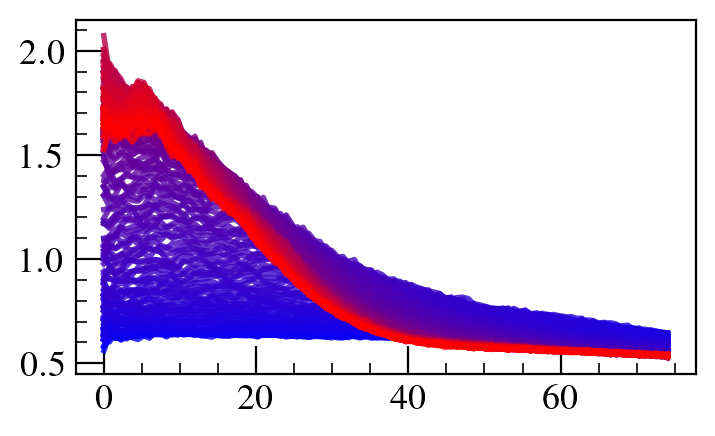

In [289]:
for i in range(200):
    plt.plot(motorSummary['r_unif_ls_um'], motorSummary['avg_ls'][i], color=(i/200, 0, 1-i/200, 0.8))

Text(0, 0.5, 'integrated motor concentration$\\int_0^r \\rho(r)~dr$')

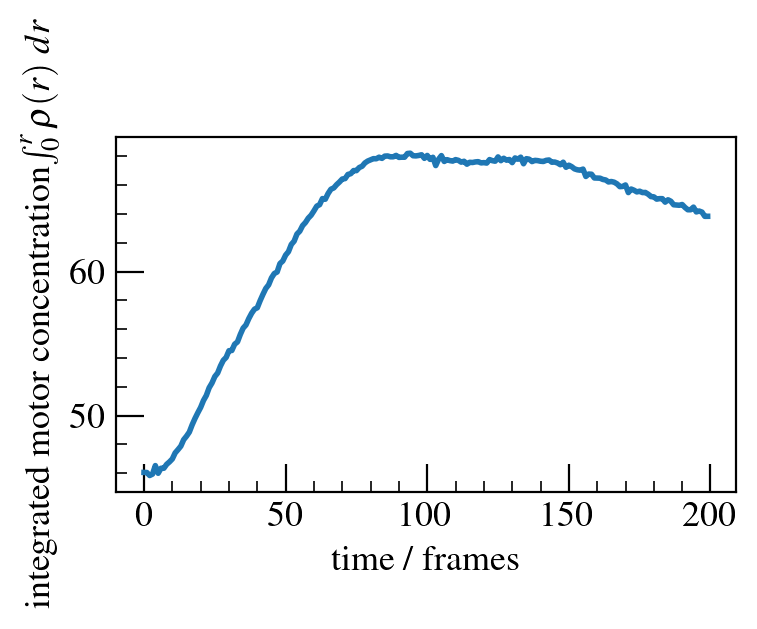

In [300]:
totMotConcs=[]
for t in range(200):
    totMotConcs.append(np.trapz(motorSummary['avg_ls'][t], motorSummary['r_unif_ls_um']))
    
plt.plot([t for t in range(200)], totMotConcs)
plt.xlabel('time / frames')
plt.ylabel('integrated motor concentration\n'+r'$\int_0^r \rho(r)~dr$')

In [290]:
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels

ATP_Summary = profile_fn(ATP_conc_ims_cropped,
           um_per_pixel,
           r_min=0,
           dr=1.5,
           r_max=int(min_dist),
           avg_method='median',
           n_positions=100,
           n_wedge=16)

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(200, 16, 100)


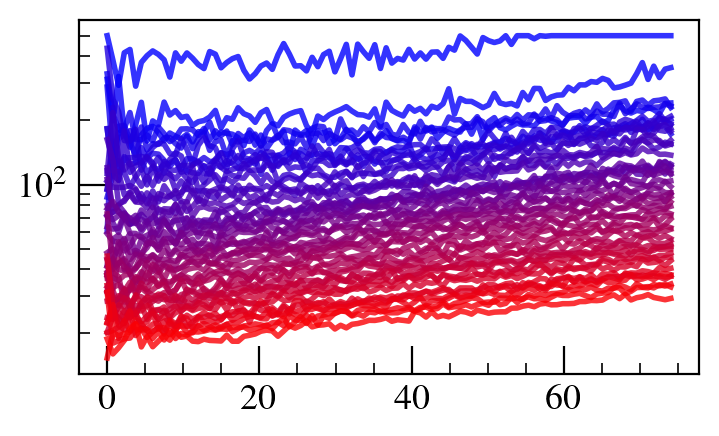

In [291]:
for i in range(0,200,4):
    plt.plot(ATP_Summary['r_unif_ls_um'], ATP_Summary['avg_ls'][i], color=(i/200, 0, 1-i/200, 0.8))
    
plt.yscale('log')

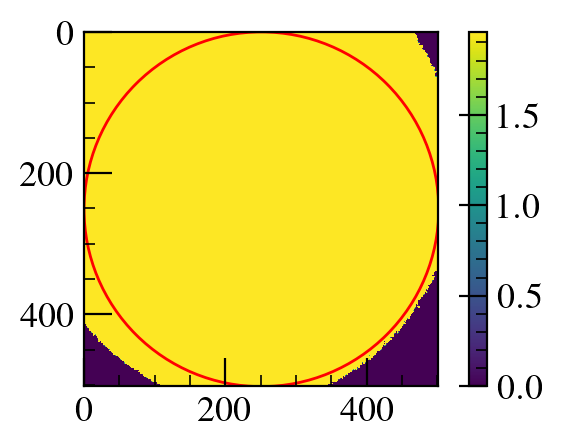

In [342]:
fig, ax = plt.subplots()
plt.imshow(ATP_conc_ims_cropped[120], vmin=0, vmax=np.percentile(mot_conc_ims_cropped, 99.9))
plt.colorbar()
circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
ax.add_patch(circ1)

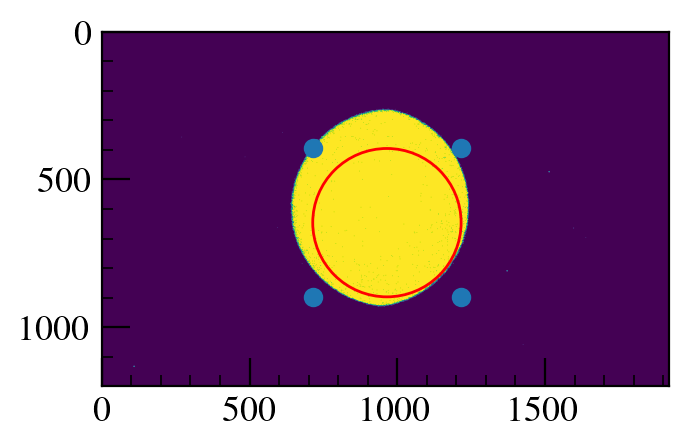

In [337]:
test=120
fig,ax=plt.subplots()
plt.imshow(mango_mask)
plt.scatter([centers[test][0]-min_dist,centers[test][0]-min_dist, centers[test][0]+min_dist, centers[test][0]+min_dist],  
           [centers[test][1]-min_dist,centers[test][1]+min_dist, centers[test][1]-min_dist, centers[test][1]+min_dist])
circ1 = patches.Circle((centers[test][0], centers[test][1]), min_dist, edgecolor='r', fill=False)
ax.add_patch(circ1)

# movies eek

Find the square that inscribes the circle

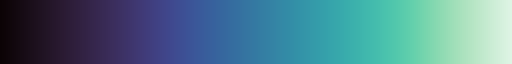

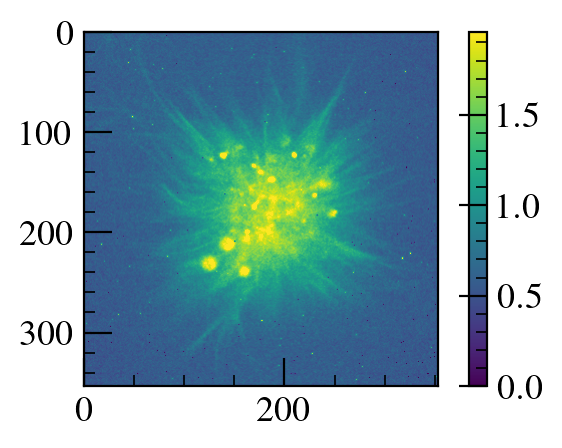

In [351]:
side_length = int(min_dist/np.sqrt(2))
inscribe_crop = np.s_[round(min_dist)-side_length:round(min_dist)+side_length,
                     round(min_dist)-side_length:round(min_dist)+side_length]
fig, ax = plt.subplots()
plt.imshow(mot_conc_ims_cropped[120][inscribe_crop], vmin=0, vmax=np.percentile(mot_conc_ims_cropped, 99.9))
          #cmap=sns.color_palette('rocket', as_cmap=True))
plt.colorbar()
# circ1 = patches.Circle((min_dist, min_dist), min_dist, edgecolor='r', fill=False)
# ax.add_patch(circ1)


# motor movie`

In [ ]:
ims = []
plot_array = mot_conc_ims_cropped
plot_times = np.arange(len(ATP_Summary['r_unif_ls_um']))*exp_params['interval']/60 #min
winsize_um = int(min_dist/np.sqrt(2))*um_per_pixel
cmap = cm.get_cmap('binary_r')
colorbar_min = np.percentile(plot_array, 0)
colorbar_max = np.percentile(plot_array, 99.99)
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)
extent = [-winsize_um, winsize_um, -winsize_um, winsize_um]

fig, ax = plt.subplots(figsize = (5,5))

ax.set_title("NCD Kinesin Motors")

camera = cell.Camera(fig)

for i, time in enumerate(tqdm(plot_times)):
    im_temp = plot_array[i]
    im = ax.imshow(im_temp,
                   vmin=colorbar_min,
                   vmax=colorbar_max,
                   cmap = cmap,
                   animated=True,
                   extent=extent,
                   zorder=0)
    ax.text(-105, 100, str(round(time, 2)), color = 'w')
    ax.text(-80, 100, " min", color = 'w')
    camera.snap()

plt.xlabel('µm')
plt.ylabel('µm')
    
animation = camera.animate()
save_path ='../../analyzed_data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'
tqdm(animation.save(save_path+"20240909_motor_movie.mp4",dpi=400))

  0%|          | 0/100 [00:00<?, ?it/s]

In [354]:
np.arange(len(ATP_Summary['r_unif_ls_um']))*exp_params['interval']/60

array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
        1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
        3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
        5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
        6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
        8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
       10.        , 10.33333333, 10.66666667, 11.        , 11.33333333,
       11.66666667, 12.        , 12.33333333, 12.66666667, 13.        ,
       13.33333333, 13.66666667, 14.        , 14.33333333, 14.66666667,
       15.        , 15.33333333, 15.66666667, 16.        , 16.33333333,
       16.66666667, 17.        , 17.33333333, 17.66666667, 18.        ,
       18.33333333, 18.66666667, 19.        , 19.33333333, 19.66666667,
       20.        , 20.33333333, 20.66666667, 21.        , 21.33333333,
       21.66666667, 22.        , 22.33333333, 22.66666667, 23.  

# Radial Trace plot

In [ ]:
plot_times = np.arange(len(ATP_Summary['r_unif_ls_um']))*exp_params['interval']

mod_num = 4

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=0.6*plot_times.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(plot_times)

for i, frame in enumerate(plot_frames):
    if i%mod_num==0:
        ax[0].plot(output_mot[i]['r_unif_ls_um'],
                 output_mot[i]['avg_ls'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))

        ax[1].plot(output_ratios[i]['r_unif_ls_um'],
                 output_ratios[i]['avg_ls_conc_units'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))

#ax[0].set_box_aspect(1.5)
#ax[1].set_box_aspect(1.5)

fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Concentration (µM)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0].set_facecolor(color_background)
ax[1].set_facecolor(color_background)

ax[0].tick_params('both', labelsize=25)
ax[1].tick_params('both', labelsize=25)
ax[1].set_ylim(0, 375)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="Times (min)", size=30, weight='bold')

# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
# cbar = plt.colorbar(scalarmappable, label = "Times (min)")

#fig.savefig('../../figures/Motor_ATP_Traces')

# scratch work

In [213]:
plt.scatter(mango_skin_coords[:,0], mango_skin_coords[:, 1], s=0.1, c='r')
plt.scatter(min_dist_coord[0][1], min_dist_coord[0][0], c='k')

plt.imshow(mot_conc_ims[min_dist_time][0], vmin=0, vmax=500)
plt.colorbar()

NameError: name 'mango_skin_coords' is not defined

In [95]:
#def shortest_dist(centers, mask_coords):
mango_mask = coords_to_mask(mask_coords, np.shape(mot_conc_ims[0]))
not_mango_mask = np.array(np.where(mango_mask==0)).T
#reshapes stuff and broadcasts to do subtraction
dists = np.sum((not_mango_mask[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2)
min_dist = np.min(np.min(dists, axis=1), axis=0)
min_coord_dist = np.argmin(np.min(dists, axis=1), axis=0)

In [99]:
np.min(dists, axis=1)

array([1246700.5       , 1245510.5       , 1244322.5       , ...,
       1657150.41261194, 1659684.82179162, 1662221.23097131])

In [75]:
dists.shape, not_mango_mask.shape

((2000469, 200), (2000469, 2))

In [111]:
not_mango_mask[min_coord_dist], mango_mask[953, 599], mango_mask_filled[953, 599]

(array([953, 599]), 0.0, False)

In [108]:
#put coordinates into binary image
mango_mask = coords_to_mask(mask_coords, np.shape(mot_conc_ims[0]))
#find the interior values (erode)
mango_flesh = binary_erosion(mango_mask_filled)
#find the border pixels
mango_skin = mango_mask - mango_flesh
#find border coordinates
skin_coords = np.argwhere(mango_skin == 1)

In [112]:
mango_mask_filled = binary_fill_holes(mango_mask)
np.unique(mango_mask_filled)

array([False,  True])

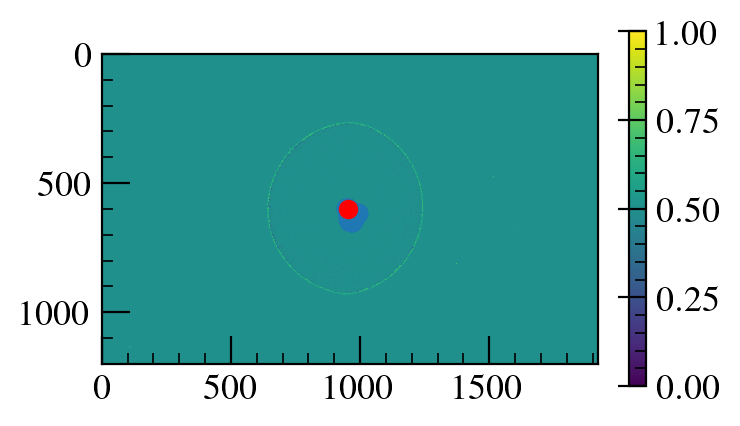

In [110]:
plt.imshow(mango_skin)
plt.scatter(centers.T[0], centers.T[1])
plt.scatter(not_mango_mask[min_coord_dist][0], not_mango_mask[min_coord_dist][1], color='r')

In [ ]:
## IN case for some reason manual for-looping is better
def allCentID(movie, mask_coords, area_thresh=0):
    results=[]
    for im in movie:
        results.append(center_identification(im, mask_coords, area_thresh))
    return results

In [ ]:
cent_and_radii[0][0]

# Find largest possible circle crop

In [ ]:
mango_mask = np.zeros_like(arrs_sub[0][0])
mango_mask[mask_coords] = 1

#find contour
mango_skin, _ = cv2.findContours(mango_mask.astype(np.uint8), 1, 2)[0]

#min dist
#START HERE ANA
dists = np.sqrt((mango_skin.T[0]-centx)**2 + (mango_skin.T[1]-centy)**2)

def largest_rad_inIllum(array, centers):
    #instantiate arrays to save radii and coordinates
    min_dists = np.zeros(len(array))
    loc_min_dists = np.zeros((len(array), 2))
    for i, im in enumerate(array):
        #define aster centers
        centx = centers[i][0]
        centy = centers[i][1]
        
        #Make binary image to isolate illumination
        otsu = skimage.filters.threshold_otsu(im)
        im_ot = im>otsu
        
        #Find contours of binary image
        contours, heirarchy = cv2.findContours(im_ot.astype(np.uint8), 1, 2)
        #iterate through contours (for most connected region)
        max_area = 0
        max_index = None
        for j, contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_index = j
                
        #Find the coordinates of the illumination pattern contour
        cnt = contours[max_index]
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)

        #Find the minimum distance between the aster center and the contour
        dists = np.sqrt((cnt.T[0]-centx)**2 + (cnt.T[1]-centy)**2)
        min_dists[i] = dists.min()
        loc_min_dists[i] = (cnt.T[0][dists.argmin()],  cnt.T[1][dists.argmin()])
        
    return min_dists, loc_min_dists

In [95]:
testim = normed_mot[100]
cent, radius = center_identification(testim, mask_coords)

In [87]:
normed_mot = arrs_norm[2]
testim = normed_mot[0]

image_blur = gaussian(testim, sigma=50)
    
#threshold
thresh = threshold_otsu(image_blur[mask_coords]) #Otsu threshold method
binary = (image_blur>thresh).astype(np.uint8)

#create a contour
contours, hierarchy = cv2.findContours(binary, 1, 2)

In [88]:
thresh

171.37013934851797

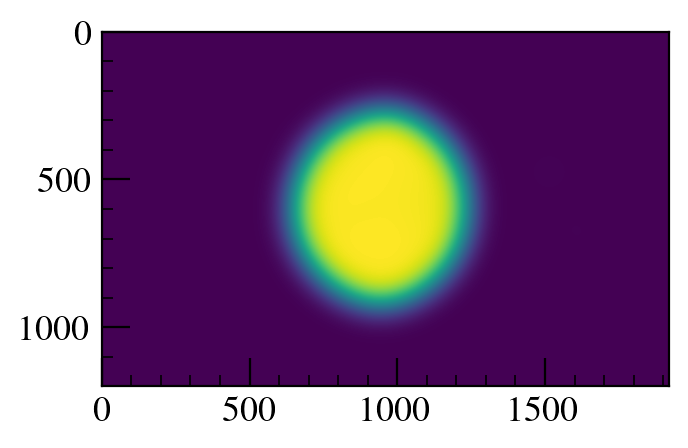

In [89]:
plt.imshow(image_blur)

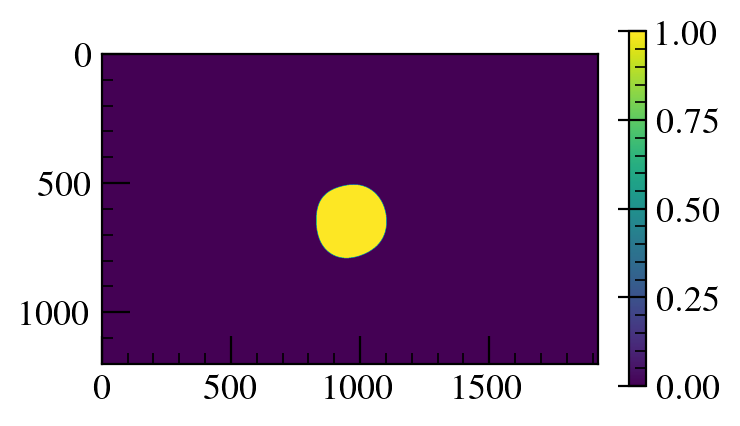

In [84]:
plt.imshow(binary, vmax=1)
plt.colorbar()

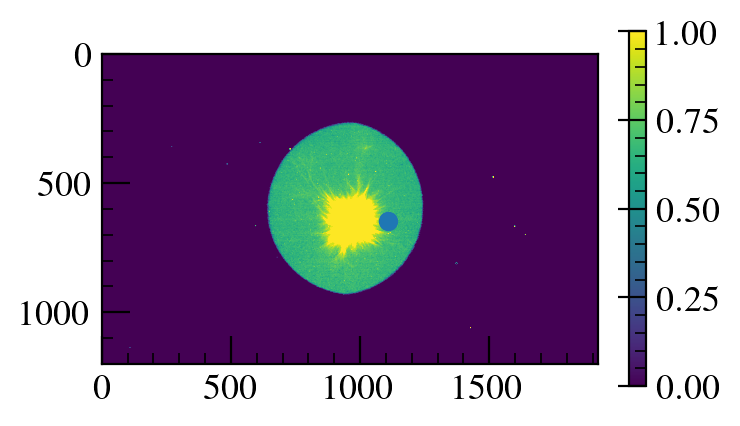

In [101]:
plt.imshow(testim, vmin=0, vmax=300)
plt.scatter([cent[0]+radius], cent[1])
plt.colorbar()

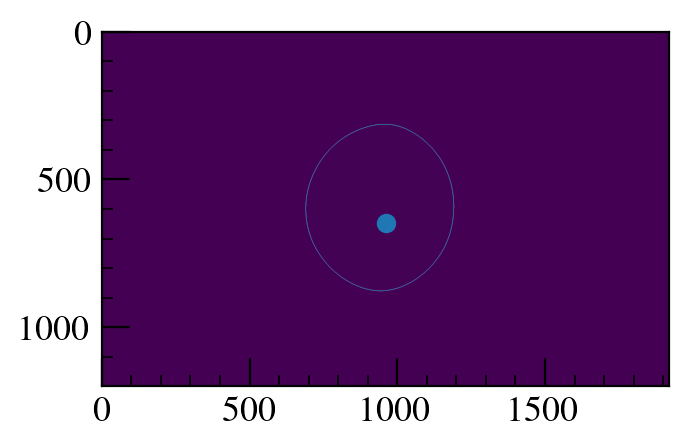

In [99]:
plt.imshow(cv2.drawContours(binary, contours, -1, color=1029))
plt.scatter(cent[0], cent[1])

### Crop
c_ymin, c_ymax, c_xmin, c_xmax = ymin_motcrop, ymax_motcrop, xmin_motcrop, xmax_motcrop
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

#init empty lists for center vals, radius, frame #
centers = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in enumerate(tqdm(mot_arraynorm)):
   
    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    
    #Create a binary mask for above a threshold
    thresh = threshold_otsu(dst) #Otsu threshold method
#     thresh = np.percentile(dst, 98.5) #Percentile threshold method
    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh and i > 10):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        #save the center, radii, and frame number
        centers.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        #fromat the contour indices for plotting
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
    
    #If the contour is not well defined for the image, abort
    else:
        print("**CENTER NOT FOUND** - Frame " + str(i))
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
#         frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)

#Convert lists to arrays
centers = np.array(centers)
radii = np.array(radii)
radii_um = radii*um_per_pixel
frame_num = np.array(frame_num)

In [25]:
# # # Load the array from the HDF5 file
# # with h5py.File(save_name, 'r') as h5file:
# #     loaded_array = h5file[save_name][:]
# plt.imshow(loaded_array[0])x

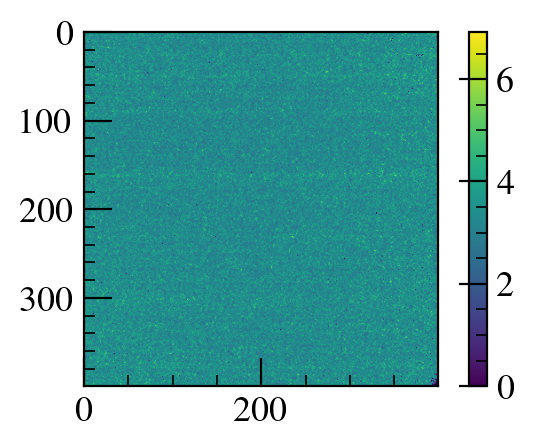

In [122]:
tempim = np.zeros_like(arrs_sub[0][0])
tempim[mask_coords]=ratios[0]
temp_crop=np.s_[400:800, 780:1180]
#plt.imshow((tempim>RinitATP)[temp_crop])
plt.imshow((tempim)[temp_crop])
plt.colorbar()

In [109]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
#     if type(r_max) != np.ndarray:
#         r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]

            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

In [123]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels


profDict=profile_fn(tempim, r_min=0, dr=1.5, r_max=200)

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


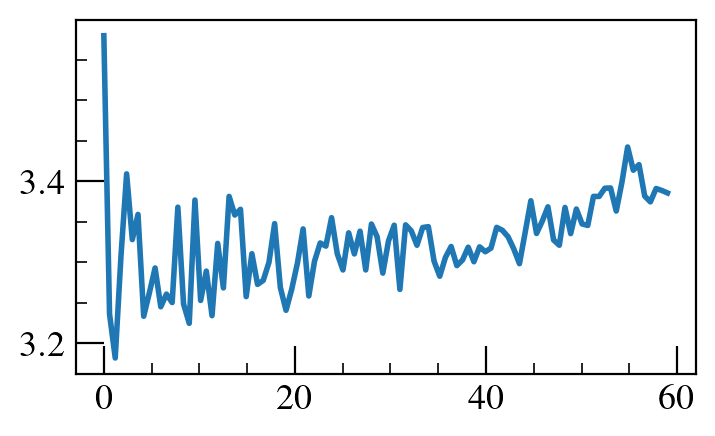

In [124]:
plt.plot(profDict['r_unif_ls_um'], profDict['avg_ls'])

True

In [ ]:
woot=(ratios[::2,:,:]+ratios[1::2,:,:])/2
woot.shape

(100, 1200, 1920)

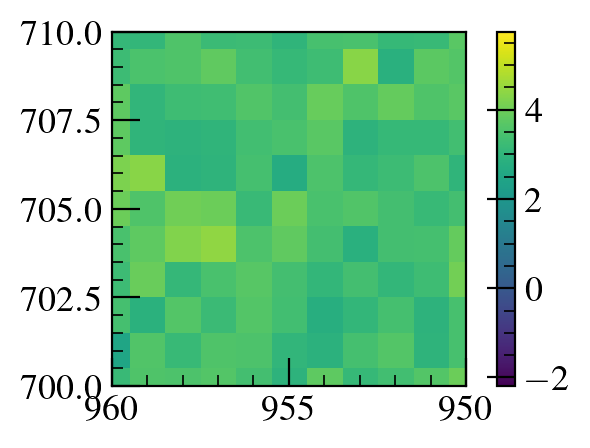

In [61]:
plt.imshow(woot[0,:,:])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

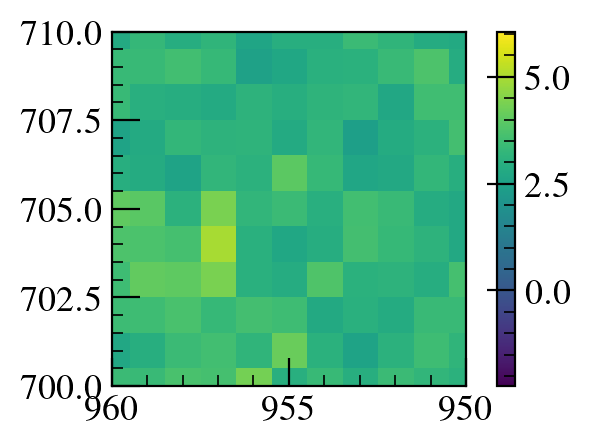

In [62]:
plt.imshow(woot[1,:,:])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

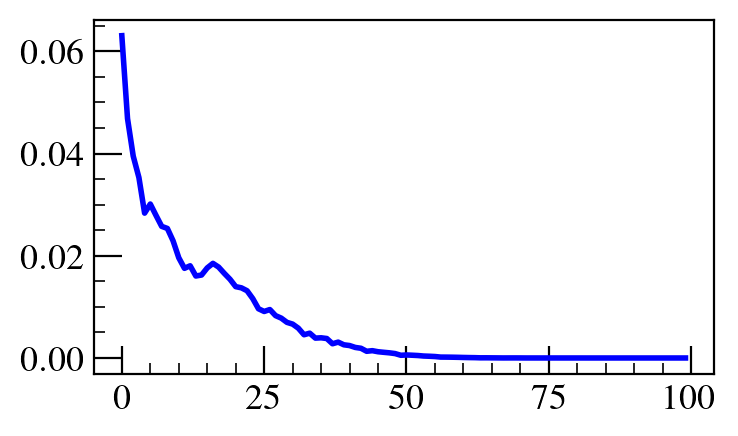

In [69]:
plt.plot([(woot[t,:,:]>=3.39).sum()/(woot.shape[1]*woot.shape[2]) for t in range(100)], 'b-')

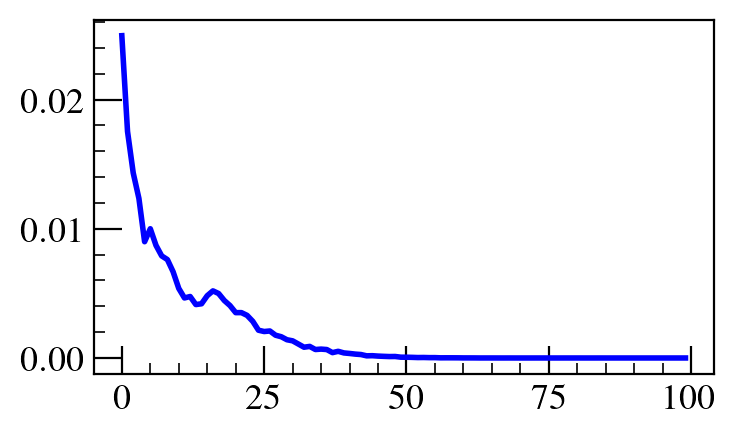

In [67]:
plt.plot([(woot[t,:,:]>=cal_params.loc['Rmax']['Value']).sum()/(woot.shape[1]*woot.shape[2]) for t in range(100)], 'b-')

In [33]:
cal_params

,Value,Uncertainty
Param,,
Km,70.232953,10
Rmax,3.718097,10
Rmin,1.036695,10
nhill,1.000000,0


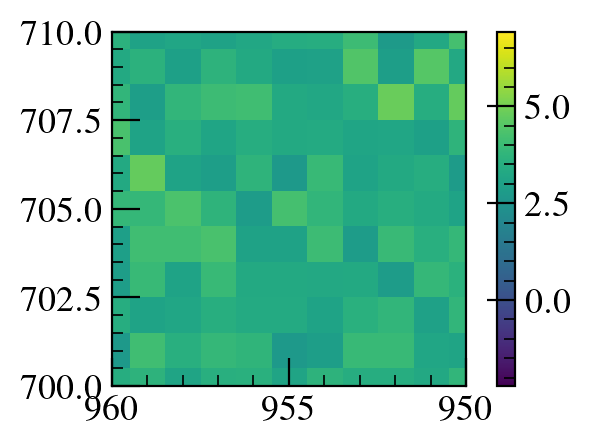

In [51]:
plt.imshow(ratios[0])#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])

plt.colorbar()

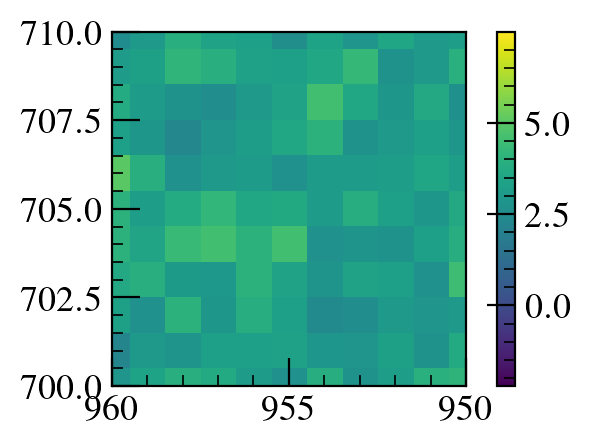

In [52]:
plt.imshow(ratios[1])#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])
plt.colorbar()

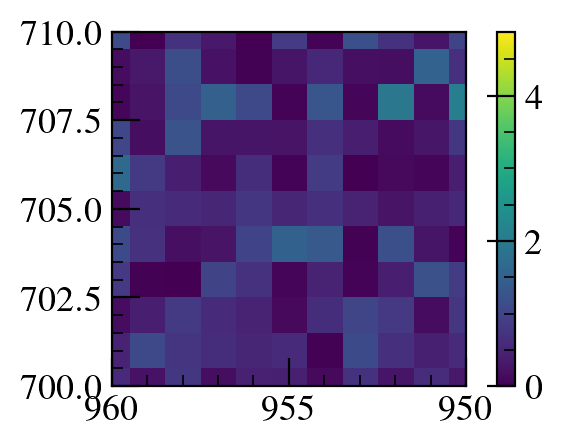

In [57]:
plt.imshow(abs(ratios[0]-ratios[1]))#>cal_params.loc['Rmax']['Value'])
plt.ylim([700,710])
plt.xlim([960, 950])

plt.colorbar()

In [53]:
cal_params.loc['Rmax']['Value']

3.718097246297439

In [47]:
abnormal[0].shape

(200, 1200, 1920)

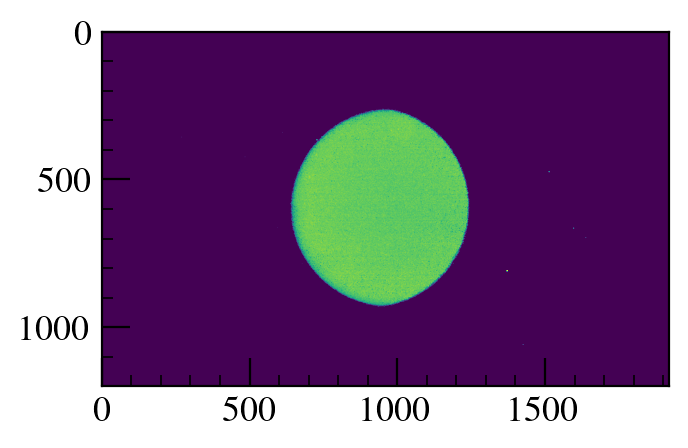

In [20]:
fig, ax = plt.subplots()
ax.imshow(abnormal[0][0,:,:],vmin=0, vmax=500)

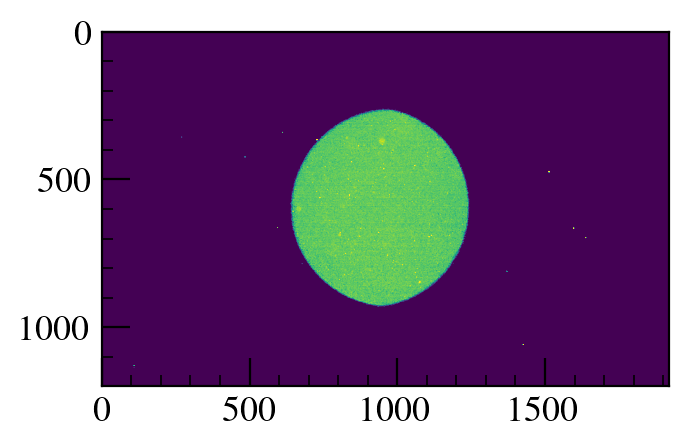

In [54]:
fig, ax = plt.subplots()
ax.imshow(abnormal[2][0,:,:],vmin=0, vmax=500)

In [26]:
np.mean(norm_mats[0][mask_coords]), np.mean(arrs_sub[0][0][mask_coords])

(380.85414669341594, 380.85414669341844)

In [27]:
np.mean(arrs_sub[0][0][mask_coords])/np.mean(arrs_sub[0][0][mask_coords]/norm_mats[0][mask_coords])

381.08343966822446

In [16]:
norm_mats = []
for arr in arrs_sub:
    norm_mat = np.zeros_like(dark_avg)
    norm_mat[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
    norm_mats.append(norm_mat)

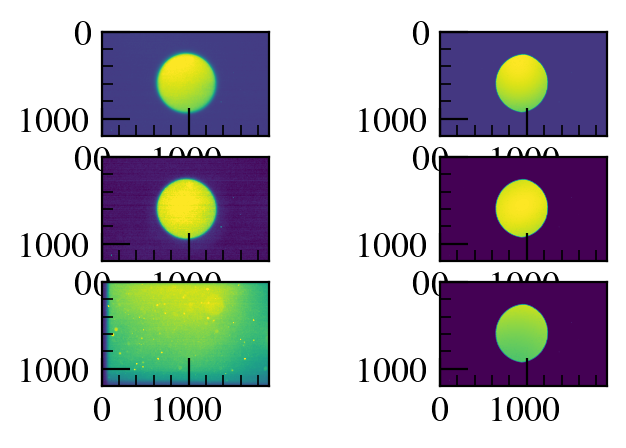

In [17]:
fig, ax = plt.subplots(3, 2)
ax[0][0].imshow(arrs_sub[0][0], vmin=norm_mats[0].min(), vmax=norm_mats[0].max())
ax[0][1].imshow(norm_mats[0])
ax[1][0].imshow(arrs_sub[1][0], vmin=norm_mats[1].min(), vmax=norm_mats[1].max())
ax[1][1].imshow(norm_mats[1])
ax[2][0].imshow(arrs_sub[2][0], vmin=norm_mats[2].min(), vmax=norm_mats[2].max())
ax[2][1].imshow(norm_mats[2])

In [113]:
testImg=arrs[0][0,:,:]
fit_bivariate_quadratic_anyShape(testImg[np.where(testBackMask)],
                                 np.where(testBackMask))

array([-3.47758592e-04, -4.53934814e-04,  1.07272348e-05,  2.26613362e-01,
        8.09367339e-01,  1.93676849e+03])

Find the illuminated region for the projector channels and apply the bivariate polynomial

next function is for circles with specified center and radius

In [ ]:
def BivPolyNormMatCirc(im, cent, radius, r_edge):
    # Make a binary image using the center and radius of the illumination patterns
    I, J = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]), indexing='ij')
    testcirc = (I-illumavgcent[1])**2+(J-illumavgcent[0])**2
    coords = np.where(testcirc<=(radius-r_edge)**2)
    vals = im[coords]
    
    #Apply the bivariate polynomial fit for the ones region
    biv_filt = evaluateBivPoly_anyShape(vals, coords)
    alpha_filt = np.nanmean(biv_filt)/biv_filt

    #put the bivariate filter in the shape of the image
    im_biv = np.zeros(im.shape)
    im_biv[coords] += biv_filt
    #put the alpha filter in the shape of the image
    alpha = np.zeros(im.shape)
    alpha[coords] += alpha_filt

    return alpha

In [ ]:
bnd_alpha = BivPolyNormMatCirc(im_arraybnd_bs[0], illumavgcent_bnd, illumradius_bnd, 30)
bnd_arraynorm = im_arraybnd_bs_nonneg*bnd_alpha

unbnd_alpha = BivPolyNormMatCirc(im_arrayunbnd_bs_nonneg[0], illumavgcent_unbnd, illumradius_unbnd, 30)
unbnd_arraynorm = im_arrayunbnd_bs_nonneg*unbnd_alpha
